In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr
from dotenv import load_dotenv
from PIL import Image


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import get_keyframe_paths, get_keyframe_path

In [64]:
load_dotenv()

CHAPTERS_DATA_TSV = Path(os.getenv("CHAPTERS_DATA_TSV")).resolve()
CONTENT_CLASSIFICATIONS_DIR = Path(os.getenv("CONTENT_CLASSIFICATIONS_DIR")).resolve()


In [65]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]
len(df)

2369

In [66]:
individual = "individual"
collective = "collective"
multiples = "multiples"
war_machinery = "war machinery"
civilians = "civilians"
landscape = "landscape"
classes = [individual, collective, multiples, war_machinery,  civilians, landscape]

def get_depiction_ratio(row: pd.Series, depiction: str) -> float | None:
    filename = row["filestem"] + "_" + row["chapter"] + ".csv"
    path = CONTENT_CLASSIFICATIONS_DIR / filename
    if not path.is_file():
        return None
    try: 
        df = pd.read_csv(path)
        n = len(df[(df["prediction"] == individual) | (df["prediction"] == collective) | (df["prediction"] == multiples)])
        if n == 0:
            return None
        shots = len(df[df["prediction"] == depiction])
        return shots / n
    except Exception as e:
        print(e)
        return None

In [67]:
dfs = []
for p in CONTENT_CLASSIFICATIONS_DIR.glob("*.csv"):
    df = pd.read_csv(p)
    dfs.append(df)

df = pd.concat(dfs)

In [68]:
df_individual = df[df["prediction"] == "individual"].copy()
df_collective = df[df["prediction"] == "collective"].copy()
df_multiples = df[df["prediction"] == "multiples"].copy()
df_war_machinery = df[df["prediction"] == "war machinery"].copy()
df_civilians = df[df["prediction"] == "civilians"].copy()
df_landscape = df[df["prediction"] == "landscape"].copy()
print(f"{individual}: {len(df_individual)/len(df)}")
print(f"{collective}: {len(df_collective)/len(df)}")
print(f"{multiples}: {len(df_multiples)/len(df)}")
print(f"{war_machinery}: {len(df_war_machinery)/len(df)}")
print(f"{civilians}: {len(df_civilians)/len(df)}")
print(f"{landscape}: {len(df_landscape)/len(df)}")

individual: 0.14295873289516217
collective: 0.1278095032862838
multiples: 0.2521711022519125
war machinery: 0.32026721258485075
civilians: 0.14356211615127681
landscape: 0.013231332830513953


In [72]:
def show_top_and_bottom(df: pd.DataFrame, cls: str):
    df_top = df[df["prediction"] == cls].sort_values("score", ascending=False).head(5)
    df_bottom = df[df["prediction"] == cls].sort_values("score", ascending=True).head(5)
    df_top["img_paths"] = df_top.apply(lambda row: get_keyframe_path(row["filestem"], row["frame"]), axis=1)
    df_bottom["img_paths"] = df_bottom.apply(lambda row: get_keyframe_path(row["filestem"], row["frame"]), axis=1)
    df_top["imgs"] = df_top["img_paths"].apply(Image.open)
    df_bottom["imgs"] = df_bottom["img_paths"].apply(Image.open)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i in range(5):
        ax = axes[0, i]
        ax.imshow(df_top["imgs"].iloc[i])
        ax.axis("off")
        ax.set_title(
            f'{df_top["filestem"].iloc[i]}\n{df_top["score"].iloc[i]:.3f}',
            fontsize=12
        )

    for i in range(5):
        ax = axes[1, i]
        ax.imshow(df_bottom["imgs"].iloc[i])
        ax.axis("off")
        ax.set_title(
            f'{df_bottom["filestem"].iloc[i]}\n{df_bottom["score"].iloc[i]:.3f}',
            fontsize=12
        )

    plt.tight_layout()
    plt.show()

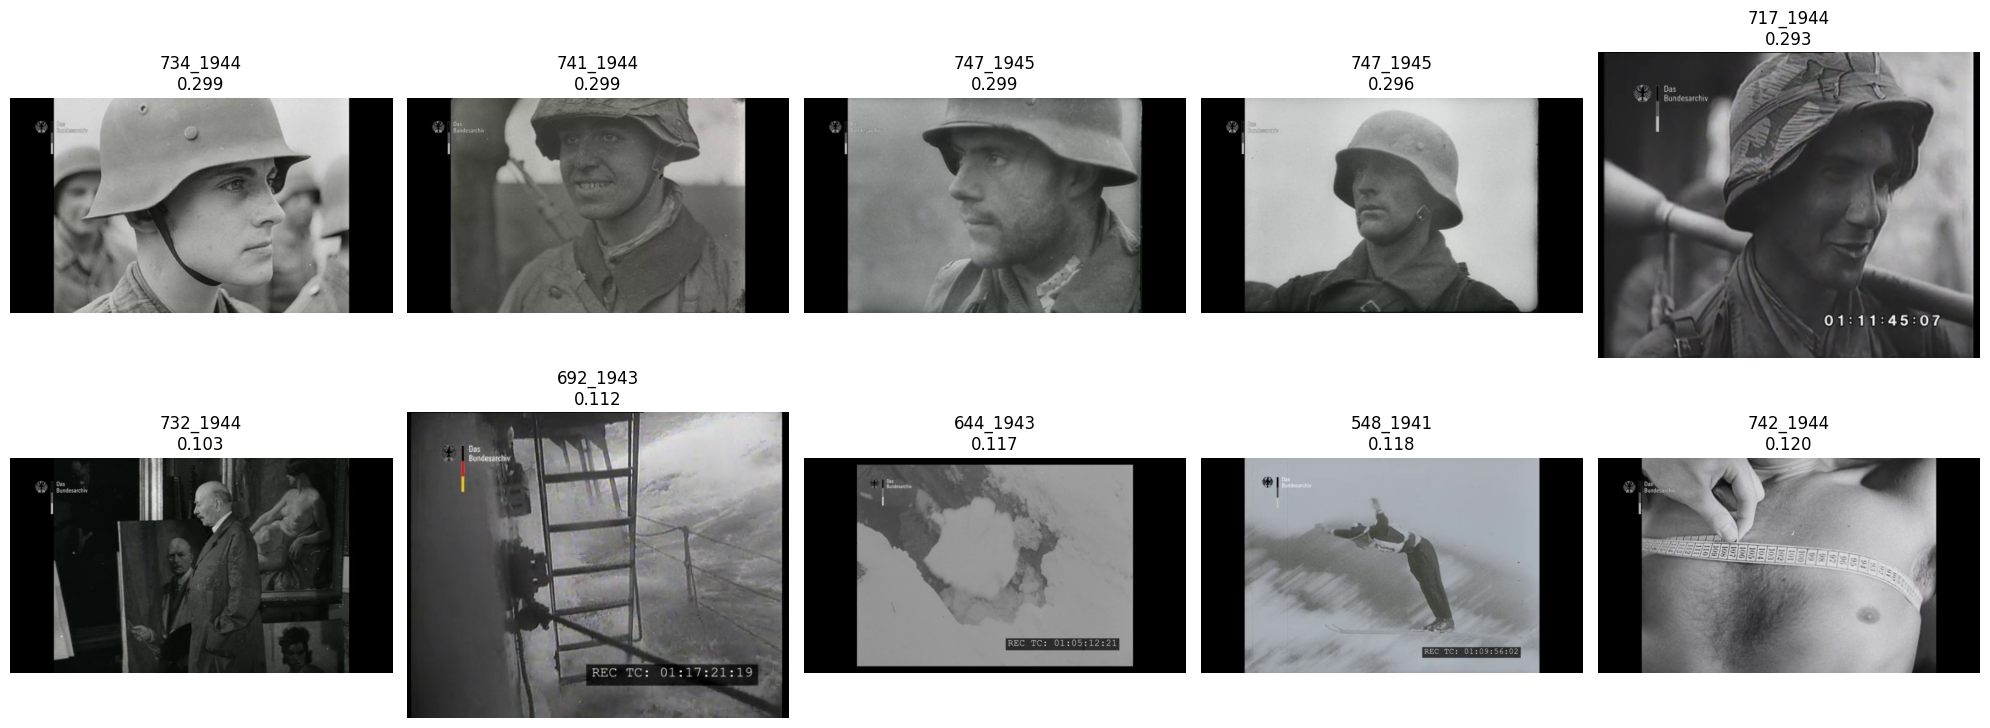

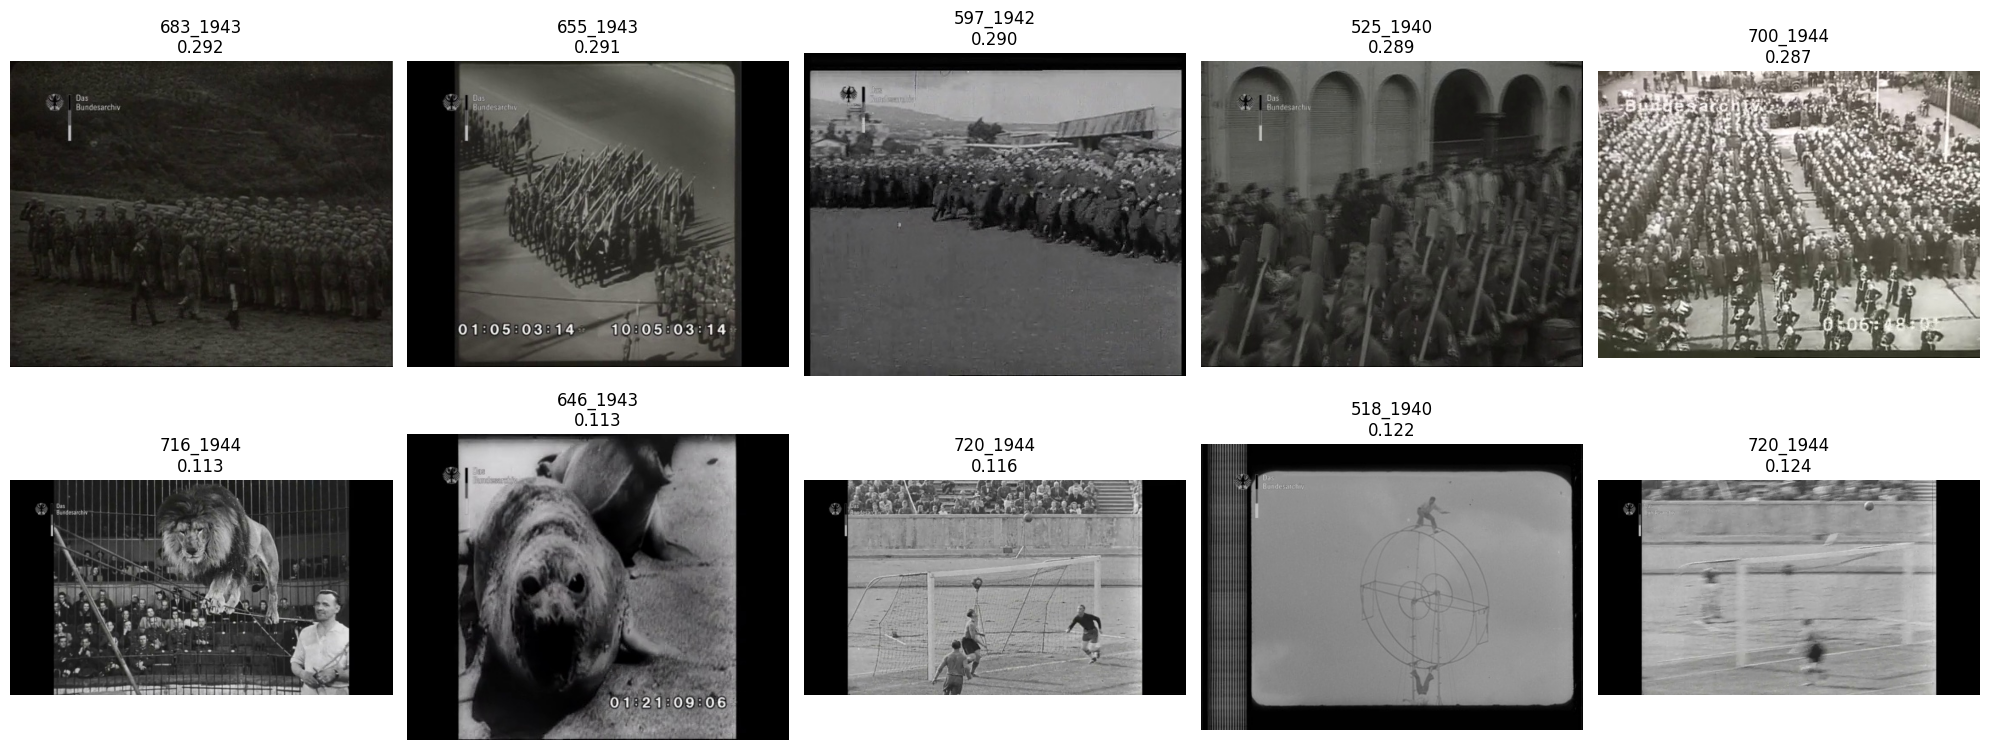

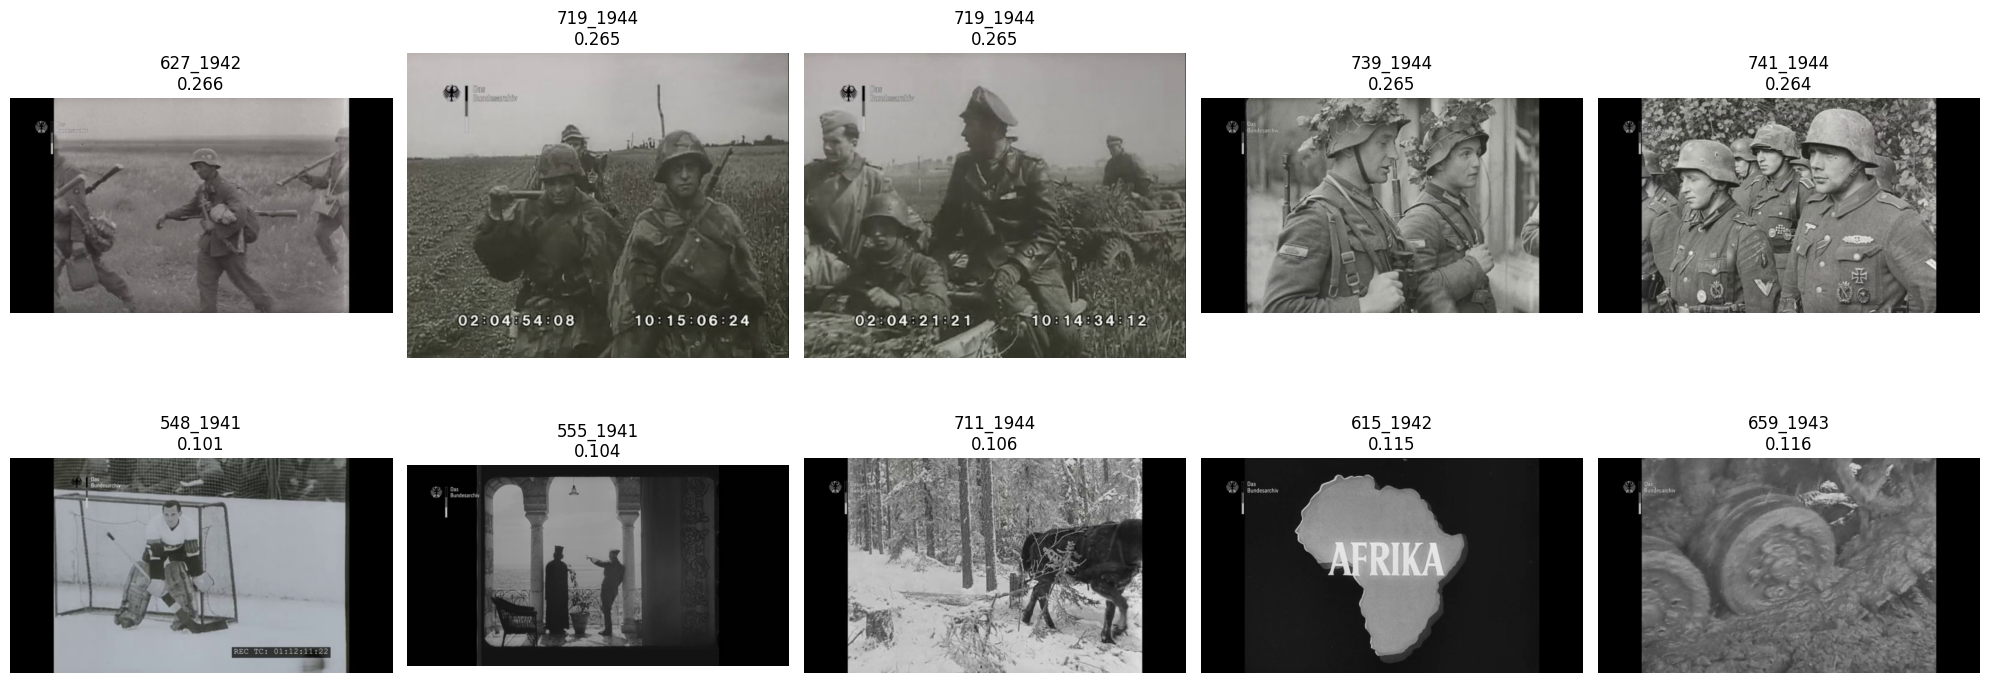

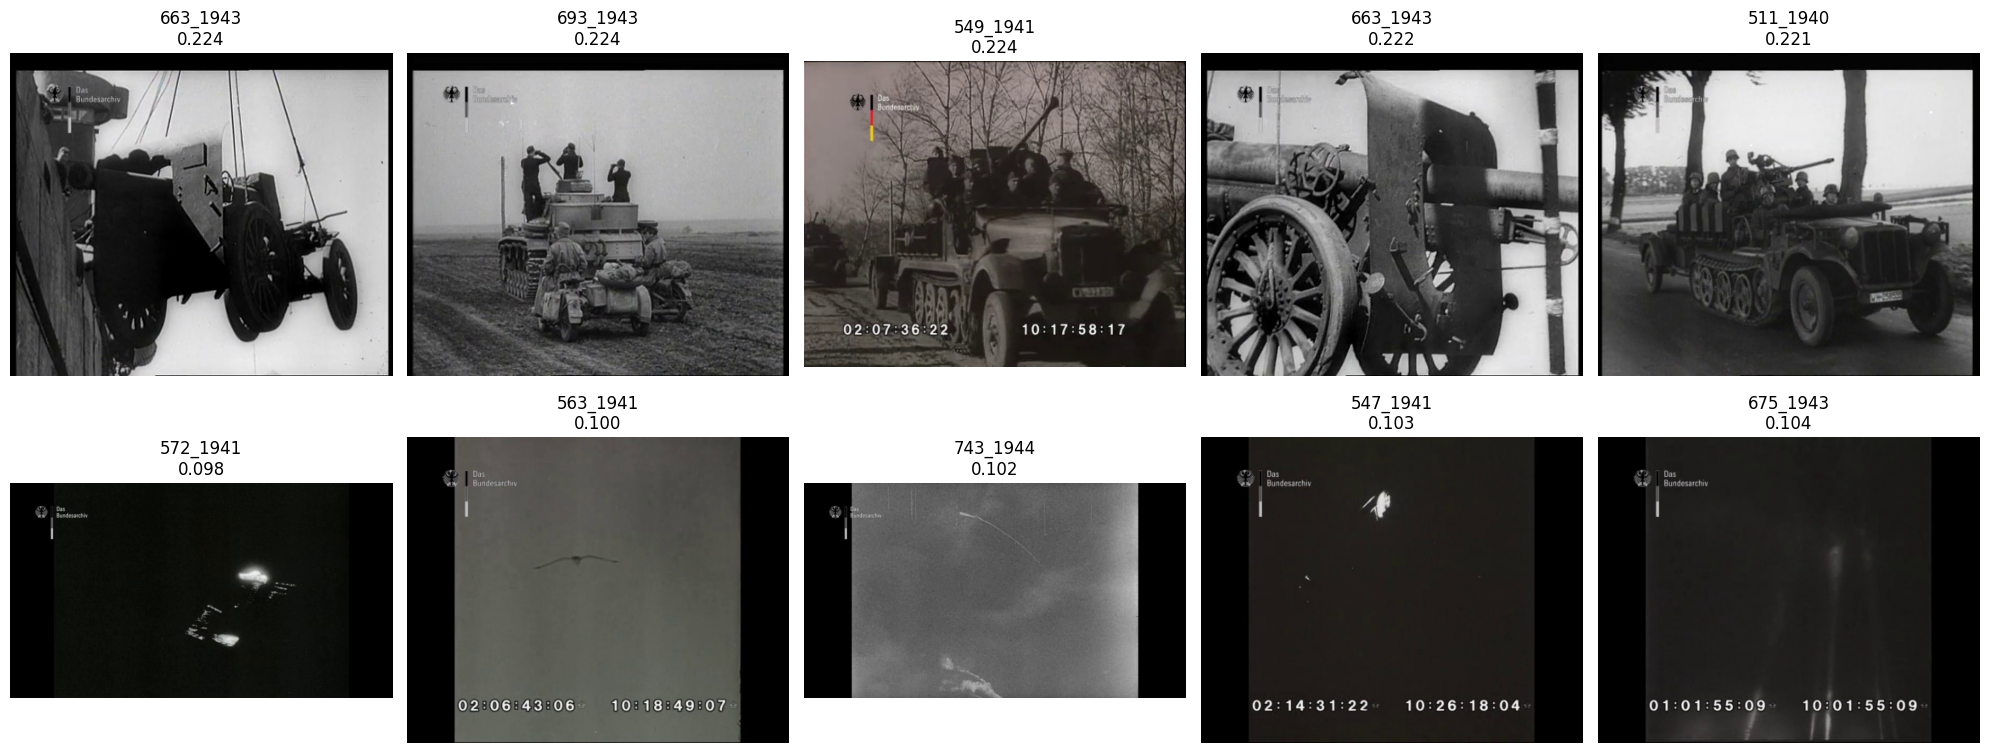

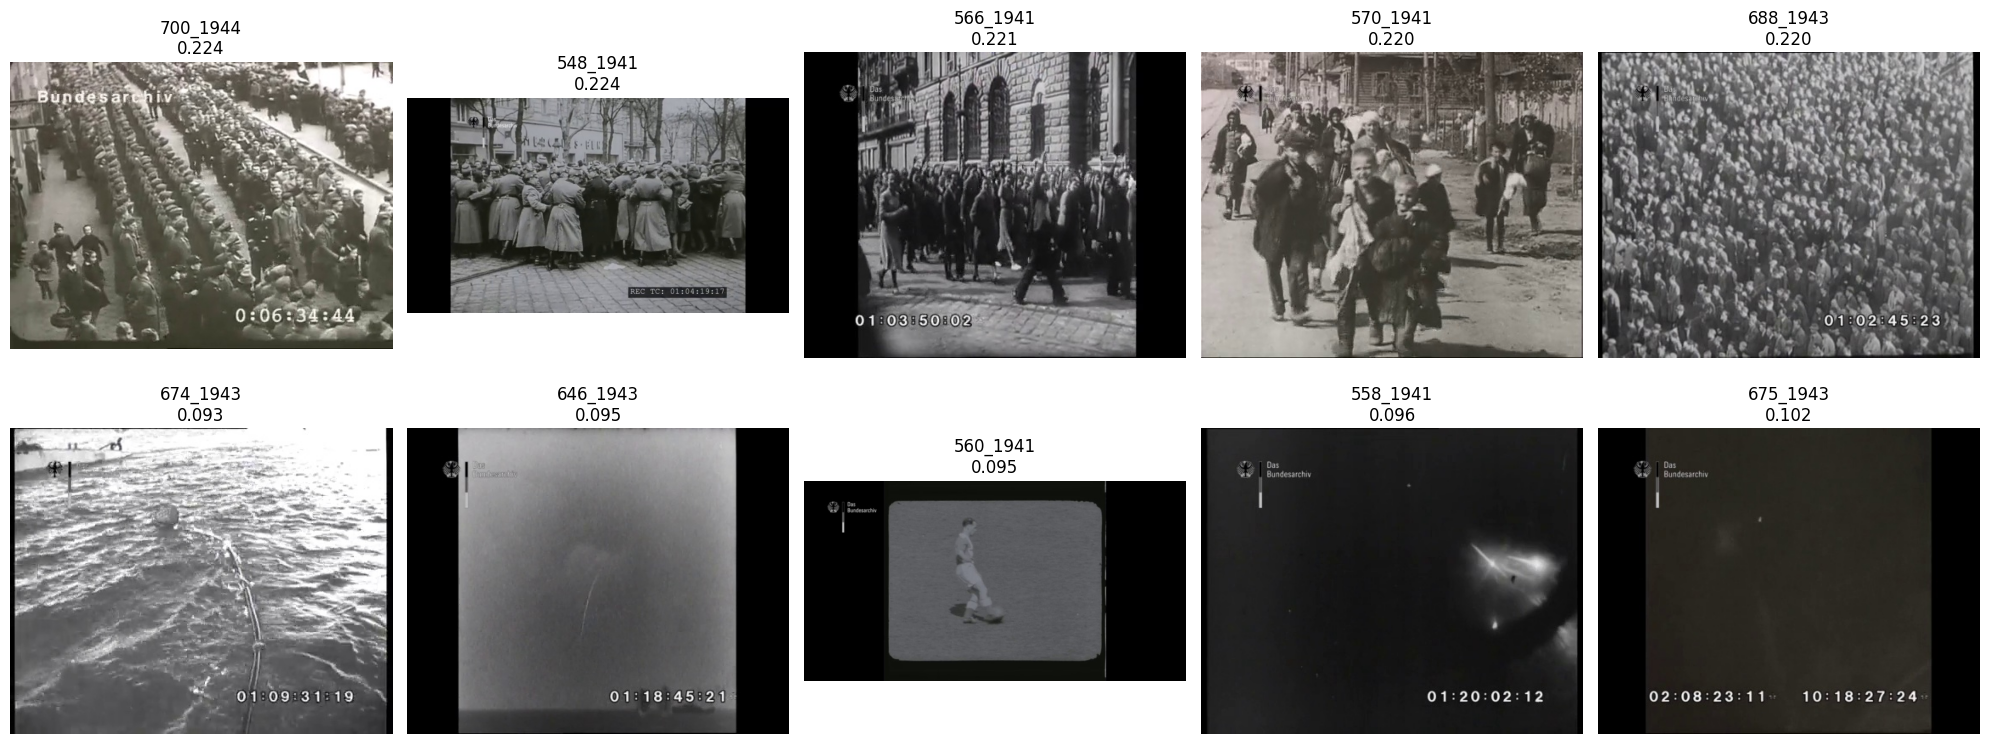

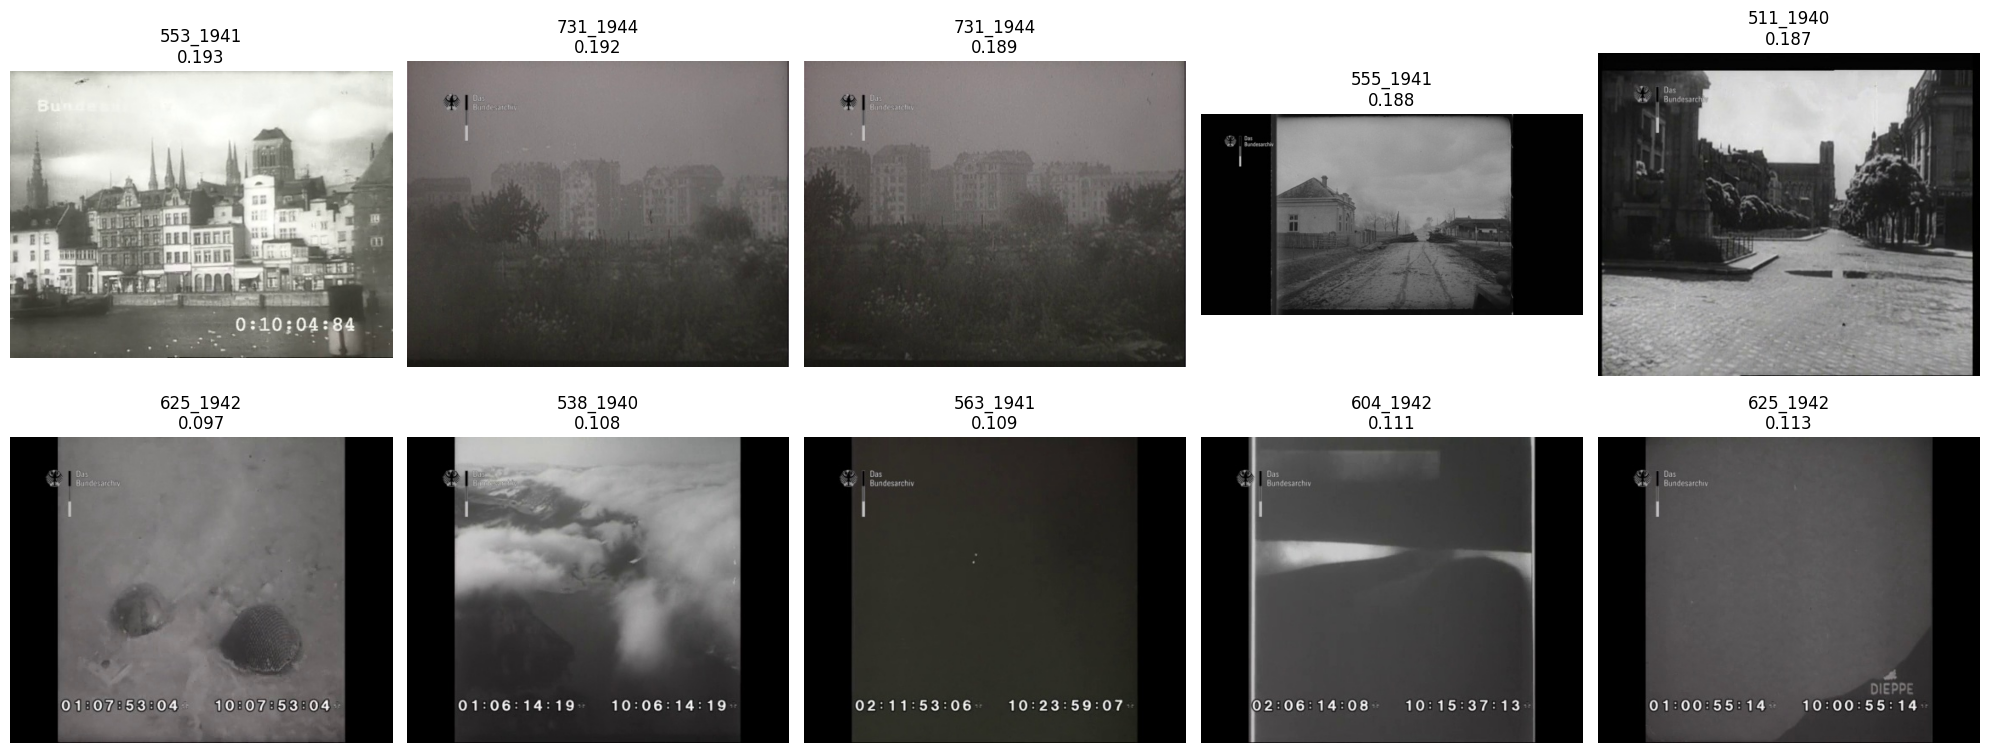

In [73]:
for cls in classes:
    show_top_and_bottom(df, cls)